In [1]:
import cv2,os
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
from utils import *

RGB = np.array([0.299, 0.587, 0.114])

e:\software\program\anaconda3\envs\mytorch\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def predictC(y, gray, X):
    '''由灰度预测通道值value为去心邻域通道,gray为该点灰度,X为去心邻域灰度二次曾广'''
    beta = np.linalg.pinv(X.T * X) * X.T*y 
    c_predict = np.linalg.det([1, gray, gray**2] * beta)
    min_=np.min(y[:2])
    max_=np.max(y[:2])
    if c_predict <= min_:
        c_predict = min_
    elif c_predict >= max_:
        c_predict = max_
    return np.round(c_predict)

def PEs(gray, img):
    '''预测误差'''
    pError = np.zeros(img.shape)
    predict = img.copy().astype(np.int32)
    # predict = img.copy()
    rho = np.zeros(gray.shape)
    # 不考虑边缘
    for i in range(2, img.shape[0] - 2):
        for j in range(2, img.shape[1] - 2):
            r = np.array([img[i + 1, j, 0], img[i, j + 1, 0], img[i + 1, j + 1, 0]]).reshape(3, 1)
            b = np.array([img[i + 1, j, 2], img[i, j + 1, 2], img[i + 1, j + 1, 2]]).reshape(3, 1)
            gr = np.array([gray[i + 1, j], gray[i, j + 1], gray[i + 1, j + 1]]).reshape(3, 1)
            X = np.mat(np.column_stack(([1] * 3, gr, gr**2)))
            predict[i, j, 0] = predictC(r, gray[i, j], X)
            predict[i, j, 2] = predictC(b, gray[i, j], X)
            rho[i, j] = np.var([gray[i - 1, j], gray[i, j - 1], gray[i, j], gray[i + 1, j], gray[i, j + 1]], ddof=1)
    # print(np.min(predict),np.min(predict))
    pError = img - predict
    return predict, pError, rho


def invariant(rgb):
    '''改变b通道灰度不变'''
    return np.round(rgb[:2].dot(RGB[:2]) + 2 * (rgb[2] // 2) * RGB[2]) \
    == np.round(rgb[:2].dot(RGB[:2]) +(2 * (rgb[2] // 2) + 1) * RGB[2])

def embedMsg(img, gray, msg, mesL, selected, predict, pError, Dt):
    IMG, GRAY, pERROR = img.copy(), gray.copy(), pError.copy()
    tags = []
    La = 0
    tagsCode = '0'
    ec = 0      # 矫正位
    location = 0
    msgIndex = 0
    ecs=[]
    xys=[]
    ecs.append(0)
    for xy in zip(*selected):
        if tags.count(0) < mesL:
            # 遍历满足rho<rhoT的像素点进行插入信息
            pERROR[xy][0] = 2 * pERROR[xy][0] + int(msg[msgIndex])
            pERROR[xy][2] = 2 * pERROR[xy][2] + ec
            ecs.append(ec)
            ec = abs(int(IMG[xy][1] - np.round((GRAY[xy] - IMG[xy][0] * RGB[0] - IMG[xy][2] * RGB[2]) / RGB[1])))
            rgb = np.array([predict[xy][loc] + pERROR[xy][loc] for loc in [0,1,2]])
            rgb[1] = np.round((GRAY[xy] - rgb[0] * RGB[0] - rgb[2] * RGB[2]) / RGB[1])
            D = np.linalg.norm(rgb - IMG[xy],ord=2)
            if np.round(rgb.dot(RGB)) != GRAY[xy]: 
                print(f'该位置{xy}无法满足灰度不变性')
                D=Dt+1
            if np.any(rgb>255) or np.any(rgb < 0)or D > Dt:
                tags.append(1)  # 设置当前的tag为非法（tag为1）
            else:
                # ecs.append(ec)
                tags.append(0)
                msgIndex += 1
                IMG[xy] = rgb
                xys.append(xy)
                # ec = abs(int(IMG[xy][1] - np.round((GRAY[xy] - IMG[xy][0] * RGB[0] - IMG[xy][2] * RGB[2]) / RGB[1])))
            
        else:
            if La == 0:
                if np.unique(tags).size > 1:
                    tagsCode= ''.join([str(char) for char in tags])
                    tagsCode=compression_encode(tagsCode)
                    La = len(tagsCode)
                else:
                    La = 1
            if location == La: break
            if invariant(IMG[xy]):
                xys.append(xy)
                IMG[xy][2] = 2 * (IMG[xy][2] // 2) + int(tagsCode[location])
                location += 1
    if len(tags) < mesL or location < La: 
        return False, ec, La, len(tags), tags,ecs,xys
    return (IMG, GRAY, pERROR), ec, La, len(tags), tags,ecs,xys

def embeding(msg,img,Dt=15,rhoT_rate=0.1):
    mesL = len(msg)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 计算 predict 以及 predication error
    predict, pError, rho = PEs(gray, img)
    PE0=np.argwhere(pError[:,:,0] + pError[:,:,2]==0)
    print('Finish calculating predication error')
    # 根据排序选 ⍴T
    rho_sorted=np.sort(rho.ravel())
    rhoT_index=int(mesL*(1+rhoT_rate))
    rhoT=int(rho_sorted[rhoT_index]*10)/10
    if rhoT_index >= rho.size or rhoT>255:
        print('picture too small Exit')
        exit()
    # 嵌入中再选 ⍴
    maxSize=(img.shape[0] - 4)*(img.shape[1] - 4)
    enough=None
    # rhoT_rateM=(rho.size-mesL)/mesL*0.5
    # rhoT=8
    while  rhoT<255 and not enough: 
        selected = [n + 2 for n in np.where(rho[2:-2, 2:-2] <= rhoT)]
        # print(selected)
        print("rhoT: %.1f, selected len: %d"%(rhoT,selected[0].size))
        if selected[0].size ==maxSize:
            print('picture too small Exit')
            exit()
        enough, lastEc, La, N, tags,ecs,xys = embedMsg(img, gray, msg, mesL, selected, predict, pError, Dt)
        # 调整Dt
        while Dt<=50 and La>mesL*0.02 and enough:
            Dt += 15
            enough, lastEc, La, N, tags,ecs,xys = embedMsg(img, gray, msg, mesL, selected, predict, pError, Dt)
            print(f'Dt: {Dt}, La: {La}')
            if Dt>50:
                enough=None
                Dt=15
                break
        if not enough: 
            rhoT_index += min(1000,int(mesL*0.1))
            rhoT_=int(rho_sorted[rhoT_index]*10)/10
            if rhoT_-rhoT<0.001:rhoT+=0.1
            else:rhoT=rhoT_

    img, gray, pError = enough
    # 整数和小数部分
    rhoT_int=int(rhoT)
    rhoT_dcm=int(rhoT*10)-rhoT_int*10

    # 在边框中嵌入参数
    border = sorted(
        list(
            set(map(tuple, np.argwhere(gray == gray))) -
            set(map(tuple,
                    np.argwhere(gray[1:-1, 1:-1] == gray[1:-1, 1:-1]) + 1))))
    border = list(filter(lambda xy: invariant(img[xy]), border))
    if len(border) < 46:
        print('image too small to contain parameters')
        exit()
    for char, loc in zip(f'{rhoT_int:08b}'+ f'{rhoT_dcm:04b}' + f'{lastEc:01b}' + f'{La:015b}' + f'{N:018b}',
                         filter(lambda xy: invariant(img[xy]), border)):
        img[loc][2] = 2 * (img[loc][2] // 2) + int(char)
    # tagsCode=''.join([str(char) for char in tags])
    print('Finish embeding parameters: '
    f'rhoT_int: {rhoT_int}, rhoT_dcm: {rhoT_dcm}, lastEc: {lastEc}, La: {La}, N: {N}'
    # f', tagsCode: {tagsCode}'
    )
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR), gray,tags,ecs,selected,xys,PE0

def extracting(imgRcv):
    # 读取嵌入信息的图片并计算其 predication error
    imgRcv = cv2.cvtColor(imgRcv, cv2.COLOR_BGR2RGB)
    grayRcv = cv2.cvtColor(imgRcv, cv2.COLOR_RGB2GRAY)
    predictRcv, pErrorRcv, rhoRcv = PEs(grayRcv, imgRcv)
    print('Finish calculating predication error from embedded image')
    
    # 提取边框的参数
    border = sorted(
        list(
            set(map(tuple, np.argwhere(grayRcv == grayRcv))) -
            set(map(tuple,
                    np.argwhere(grayRcv[1:-1, 1:-1] == grayRcv[1:-1, 1:-1]) + 1))))
    border = [str(imgRcv[loc][2] % 2) for loc in filter(lambda xy: invariant(imgRcv[xy]), border)]
    rhoT_int = int(''.join(border[:8]), 2)
    rhoT_dcm = int(''.join(border[8:12]), 2)
    rhoT=round(rhoT_int+0.1*rhoT_dcm,1)
    lastEc = int(''.join(border[12:13]), 2)
    La = int(''.join(border[13:28]), 2)
    N = int(''.join(border[28:46]), 2)
    selected = [tuple(n + 2) for n in np.argwhere(rhoRcv[2:-2, 2:-2] <= rhoT)]
    # print(selected)
    print(
        f'Finish extractig parameters: rhoT: {rhoT}, lastEc: {lastEc}, La: {La}, N: {N}'
        # f', tagsCode: {"".join([str(i) for i in tagsCode])}'
    )
    if La==1:
        tagsCode=[0] * N
    else:
        tagsCode = [imgRcv[value][2] % 2
                    for value in filter(lambda xy: invariant(imgRcv[xy]), selected[N:])][:La] 
        print("".join([str(i) for i in tagsCode]))
        tagsCode = [int(j) for j in compression_decode("".join([str(i) for i in tagsCode]))]
    
    # 根据参数提取嵌入信息
    candidate = reversed([selected[:N][index] for index, value in enumerate(tagsCode) if value == 0])
    predictRcv = imgRcv.copy().astype(np.int32)
    pErrorRcv = np.zeros(imgRcv.shape)
    msgRcv = ''
    ecs=[lastEc]
    for i in candidate:
        rM = np.array([imgRcv[i[0] + 1, i[1], 0], imgRcv[i[0], i[1] + 1, 0],
                       imgRcv[i[0] + 1, i[1] + 1, 0]]).reshape(3, 1)
        bM = np.array([imgRcv[i[0] + 1, i[1], 2], imgRcv[i[0], i[1] + 1, 2],
                       imgRcv[i[0] + 1, i[1] + 1, 2]]).reshape(3, 1)
        grM = np.array([grayRcv[i[0] + 1, i[1]], grayRcv[i[0], i[1] + 1], grayRcv[i[0] + 1, i[1] + 1]]).reshape(3, 1)
        X = np.mat(np.column_stack(([1] * 3, grM, grM**2)))
        predictRcv[i][0] = predictC(rM, grayRcv[i], X)
        predictRcv[i][2] = predictC(bM, grayRcv[i], X)
        pErrorRcv[i] = imgRcv[i] - predictRcv[i]

        msgRcv += str(int(pErrorRcv[i][0]) % 2)

        nextEc = pErrorRcv[i][2] % 2
        ecs.append(nextEc)
        pErrorRcv[i] = pErrorRcv[i] // 2
        imgRcv[i] = predictRcv[i] + pErrorRcv[i]
        imgRcv[i][1] = np.round((grayRcv[i] - imgRcv[i][0] * RGB[0] - imgRcv[i][2] * RGB[2]) / RGB[1])
        if lastEc != 0:
            if np.round(np.array([imgRcv[i][0], imgRcv[i][1] + lastEc, imgRcv[i][2]]).dot(RGB)) == grayRcv[i]:
                imgRcv[i][1] += lastEc
            elif np.round(np.array([imgRcv[i][0], imgRcv[i][1] - lastEc, imgRcv[i][2]]).dot(RGB)) == grayRcv[i]:
                imgRcv[i][1] -= lastEc
        else:
            if np.round(np.array([imgRcv[i][0], imgRcv[i][1], imgRcv[i][2]]).dot(RGB)) != grayRcv[i]:
                print(f"index {i} has no matched ec")
        lastEc = abs(nextEc)
    msgRcv=msgRcv[::-1]
    return cv2.cvtColor(imgRcv, cv2.COLOR_RGB2BGR), grayRcv, msgRcv,tagsCode,ecs[::-1]
    

In [4]:

hostName = 'test2.jpg'
msgName='msg.jpg'

dataPath = r"./data" 
msgFile=os.path.join(dataPath,msgName)
imgFile=os.path.join(dataPath,hostName)
embeddedFile = os.path.join(dataPath,f"{hostName.split('.')[0]}_embedded.png")

msg=cv2.imread(msgFile,cv2.CV_8UC1)
cv2.imshow('1',msg)
cv2.waitKey(0)
print(msg.shape)
ret, msg = cv2.threshold(msg, 200, 255, cv2.THRESH_BINARY)
img = cv2.imread(imgFile)
# plt.hist(msg.ravel(), 256)
# plt.show(block=False)

msg[msg>0]=1
msgC=encode_img(msg)
msgC=compression_encode(msgC)
# msg = "This paper studies the problem of nonparametric estimation of a smooth function with data distributed across multiple machines. We assume an independent sample from a white noise model is collected at each machine, and an estimator of the underlying true function needs to be constructed at a central machine. We place limits on the number of bits that each machine can use to transmit information to the central machine. Our results give both asymptotic lower bounds and matching upper bounds on the statistical risk under various settings. We identify three regimes, depending on the relationship among the number of machines, the size of data available at each machine, and the communication budget. When the communication budget is small, the statistical risk depends solely on this communication bottleneck, regardless of the sample size. In the regime where the communication budget is large, the classic minimax risk in the non-distributed estimation setting is recovered. In an intermediate regime, the statistical risk depends on both the sample size and the communication budget"
# msgC=encode_str(msg)


imgM,gray,tag,ecs,selected,xys,PE0=embeding(msgC,img,Dt=15,rhoT_rate=0.1)
# cv2.imwrite(embedded_file,imgM,    [cv2.IMWRITE_PNG_COMPRESSION, 9])
cv2.imwrite(embeddedFile,imgM)


# imgM=cv2.imread(embedded_file)
imgR,grayR,msgR,tagR,ecsR=extracting(imgM)

# print('tag',np.argwhere(tag != tagR),tag.count(1))
# print('ec',np.argwhere(ecs != ecsR),ecs.count(1))

# msgR=decode_str(msgR)

msgR=compression_decode(msgR)
msgR=decode_img(msgR).astype(np.uint8)
msgR[msgR > 0] = 255
# plt.hist(msgR.ravel(), 256)
# plt.show(block=False)
cv2.imshow('1',msgR)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite(os.path.join(dataPath,'msg_extract.jpg'),msgR)

# print(f"received msg errors: {np.argwhere(msg != msgR)}")
# print(f'grayscale invariant errors: {np.argwhere(gray != grayR)}')
# print(f'rgb invariant  errors: {np.argwhere(img != imgR)}')

# # 验证灰度不变性    # 准备嵌入前后灰度对比图
# plt.figure(figsize=(12, 6)), plt.suptitle('Grayscale')
# plt.subplot(1, 2, 1), plt.title('Origin')
# plt.hist(gray.ravel(), 256)
# plt.subplot(1, 2, 2), plt.title('Modified')
# plt.hist(grayR.ravel(), 256)
# plt.show(block=False)
# # plt.savefig(os.path.join(dataPath,'Grayscale.png'))
# plt.show()

(164, 294)
Finish calculating predication error
rhoT: 0.2, selected len: 20801
rhoT: 0.3, selected len: 35410
Finish embeding parameters: rhoT_int: 0, rhoT_dcm: 3, lastEc: 1, La: 1, N: 20919
Finish calculating predication error from embedded image
Finish extractig parameters: rhoT: 0.3, lastEc: 1, La: 1, N: 20919


True

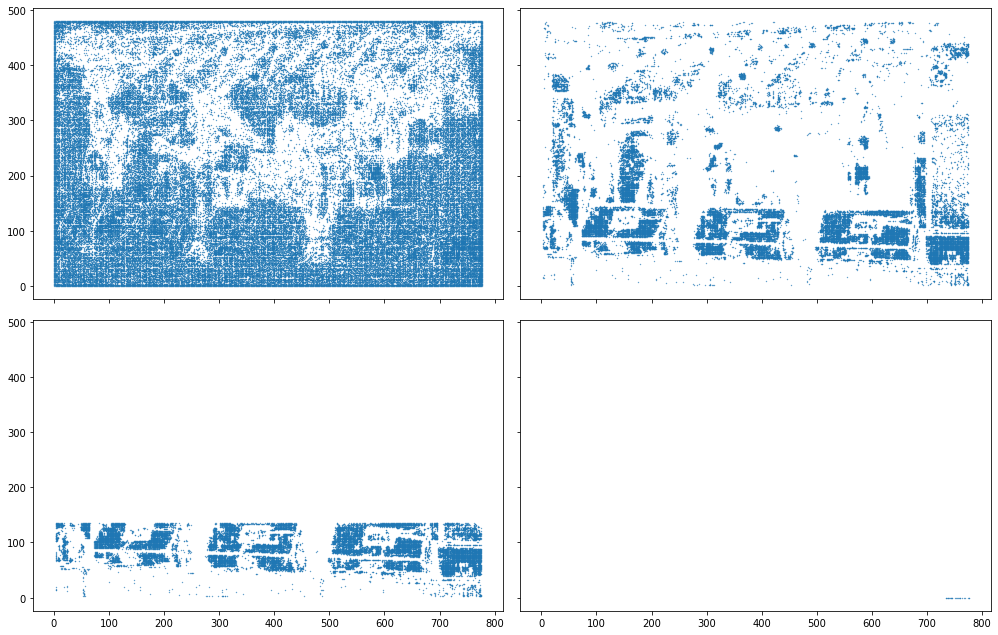

In [5]:
imgErr=np.argwhere(imgR != img)
imgErr=np.array_split(imgErr,2,axis=1)[0]
xys=np.array(xys)

fig, ax = plt.subplots(2, 2, sharey=True,sharex=True,figsize=(14,9))

# PE为0的点
# ax[0,0].scatter(PE0[:,1],img.shape[0]-PE0[:,0],s=0.1)
ax[0,0].scatter(img.shape[1]-PE0[:,1],PE0[:,0],s=0.1)
ax[0,0].set_aspect(1)
# rhoT下可嵌入点
# ax[0].scatter(selected[1],img.shape[0]-selected[0],s=0.1)
ax[0,1].scatter(img.shape[1]-selected[1],selected[0],s=0.1)
ax[0,1].set_aspect(1)
# 实际嵌入点
# ax[1].scatter(xys[:,1],img.shape[0]-xys[:,0],s=0.1)
ax[1,0].scatter(img.shape[1]-xys[:,1],xys[:,0],s=0.1)
ax[1,0].set_aspect(1)
# 还原误差点
# ax[2].scatter(imgErr[:,1],img.shape[0]-imgErr[:,0],s=0.1)
ax[1,1].scatter(img.shape[1]-imgErr[:,1],imgErr[:,0],s=0.1)
ax[1,1].set_aspect(1)

plt.tight_layout()
plt.show()

In [6]:
# evaluate
msgR[msgR > 0] = 1
print('msg NCC',ncc(msgR,msg))
print('msg acc',np.sum(msg==msgR)/msg.size)
grayR=cv2.cvtColor(imgR,cv2.COLOR_BGR2GRAY)
print('gray acc',np.sum(gray==grayR)/gray.size)
ssim=[]
psnr=[]
for ic in [0,1,2]:
    vc=img[:,:,ic]
    vcR=imgM[:,:,ic]
    ssim.append(structural_similarity(vc,vcR))
    psnr.append(peak_signal_noise_ratio(vc,vcR))
print('嵌入SSIM',round(np.mean(ssim),4),ssim)
print('嵌入PSNR',round(np.mean(psnr),4),psnr)
ssim=[]
psnr=[]
for ic in [0,1,2]:
    vc=img[:,:,ic]
    vcR=imgR[:,:,ic]
    ssim.append(structural_similarity(vc,vcR))
    psnr.append(peak_signal_noise_ratio(vc,vcR))
print('恢复SSIM',round(np.mean(ssim),4),ssim)
print('恢复PSNR',round(np.mean(psnr),4),psnr)

msg NCC 0.9999999999999998
msg acc 1.0
gray acc 1.0
嵌入SSIM 0.9995 [0.9994634633337595, 0.9997066020944869, 0.9994656737536738]
嵌入PSNR 63.1508 [62.30644619811404, 64.8928561057334, 62.252979952815586]
恢复SSIM 1.0 [0.999999870240738, 1.0, 1.0]
恢复PSNR inf [90.05435214331051, inf, inf]


e:\software\program\anaconda3\envs\mytorch\lib\site-packages\skimage\metrics\simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


In [ ]:
# 低通、高斯、中值滤波，椒盐、高斯噪声
def BLPF(image, D0,n=1):
    L = np.empty_like(image, float)
    h, w = image.shape
    # print(h, w)
    # for k in range(0, c):
    for i in range(h):
        for j in range(w):
            d = np.sqrt((i - int(h / 2)) ** 2 + (j - int(w / 2)) ** 2)
            L[i, j] = 1 / (1 + (d / D0) ** (2*n))
    return L
 
def fft(image, L):
    dft = np.fft.fft2(image)
    dftshift = np.fft.fftshift(dft)
    rs = dftshift * L
 
    idft_shift = np.fft.ifftshift(rs)
    idft = np.fft.ifft2(idft_shift)
    result = np.real(idft)
    return np.uint8(result)



imgAttack=imgM.copy()
# 高斯噪声
# gauss = np.random.normal(0,0.3,(img.shape))
# # cv2.imshow('',gauss)
# # cv2.waitKey(0)

# imgAttack[2:-2,2:-2,:] += gauss[2:-2,2:-2,:].astype(np.uint8)
# imgAttack = np.clip(imgAttack,a_min=0,a_max=255).astype(np.uint8)

# # 椒盐噪声
# s_vs_p = 0.5
# #设置添加噪声图像像素的数目
# amount = 0.00001
# #添加salt噪声
# num_salt = np.ceil(amount * imgAttack.size * s_vs_p)
# #设置添加噪声的坐标位置
# coords = [np.random.randint(0,i - 1, int(num_salt)) for i in imgAttack.shape]
# imgAttack[coords[0],coords[1],:] = [255,255,255]
# #添加pepper噪声
# num_pepper = np.ceil(amount * imgAttack.size * (1. - s_vs_p))
# #设置添加噪声的坐标位置
# coords = [np.random.randint(0,i - 1, int(num_pepper)) for i in imgAttack.shape]
# imgAttack[coords[0],coords[1],:] = [0,0,0]

# 中值、高斯滤波
# imgAttack[2:-2,2:-2,:] = cv2.medianBlur(imgM[2:-2,2:-2,:], 3)
imgAttack[2:-2,2:-2,:]=cv2.GaussianBlur(imgM[2:-2,2:-2,:],(3,3),0.3)
# # 巴特沃斯低通
# for k in range(3):
#     imgAttack[2:-2,2:-2,k]=fft(imgM[2:-2,2:-2,k], BLPF(imgM[2:-2,2:-2,k], 1024,1))

# cv2.imwrite('./data/noisy.png',imgAttack)
cv2.imshow('',imgAttack)
cv2.waitKey(0)

ssim=[]
for ic in [0,1,2]:
    vc=imgAttack[:,:,ic]
    vcR=imgM[:,:,ic]
    ssim.append(structural_similarity(vc,vcR))
print('攻击',round(np.mean(ssim),4),ssim)



攻击 1.0 [0.9999982615251742, 0.9999983329107622, 0.9999983979672503]


In [ ]:
# 形变攻击
def rotate(img,angle):
    (h, w) = img.shape[:2] 
    cX, cY = round(w // 2), round(h // 2) #
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    return cv2.warpAffine(img, M, (nW, nH))


imgAttack=imgM.copy()
# 裁剪
# imgAttack[160:200,250:290,:]=np.ones(imgAttack[160:200,250:290,:].shape)*255
# 旋转
# imgRotate=imgAttack[2:-2,2:-2,:]
# (h0, w0) = imgRotate.shape[:2] 
# cX, cY = w0 // 2, h0 // 2 
# imgRotate=rotate(imgRotate,180)
# imgRotate=rotate(imgRotate,-180)
# (h, w) = imgRotate.shape[:2] 
# nX, nY = round(w // 2), round(h // 2) 
# imgRotate=imgRotate[nY-cY:nY+cY,nX-cX:nX+cX,:]
# imgRotate=cv2.resize(imgRotate,(w0,h0))
# imgAttack[2:-2,2:-2,:]=imgRotate

# 缩放
# (h0, w0) = imgAttack.shape[:2] 
# imgAttack=cv2.resize(imgAttack,(w0*2,h0*2))
# imgAttack=cv2.resize(imgAttack,(w0,h0))

cv2.imshow('',imgAttack)
cv2.waitKey(0)

ssim=[]
for ic in [0,1,2]:
    vc=imgAttack[:,:,ic]
    vcR=imgM[:,:,ic]
    ssim.append(structural_similarity(vc,vcR))
print('攻击',round(np.mean(ssim),4),ssim)

攻击 0.9897 [0.9890846226893224, 0.9898027556937853, 0.9902058445058393]


In [ ]:
# 压缩
# cv2.imwrite(embeddedFile,imgM,    [cv2.IMWRITE_PNG_COMPRESSION, 9])     #越小质量越高
# imgCompression=cv2.imread(embeddedFile)

cv2.imwrite('./data/attack.jpg',imgM,    [cv2.IMWRITE_JPEG_QUALITY, 100])  #越小压缩损失越多
imgCompression=cv2.imread('./data/attack.jpg')

imgAttack=imgM.copy()
imgAttack[2:-2,2:-2,:]=imgCompression[2:-2,2:-2,:]
ssim=[]
for ic in [0,1,2]:
    vc=imgAttack[:,:,ic]
    vcR=imgM[:,:,ic]
    ssim.append(structural_similarity(vc,vcR))
print('攻击',round(np.mean(ssim),4),ssim)

攻击 0.9956 [0.9932603707298235, 0.9975726431775891, 0.9960348834498682]


In [ ]:
imgR,grayR,msgR,tagR,ecsR=extracting(imgAttack)
# imgR,grayR,msgR,tagR,ecsR=extracting(imgM)

msgR=compression_decode(msgR)
msgR=decode_img(msgR).astype(np.uint8)

msgR[msgR > 0] = 255
# plt.hist(msgR.ravel(), 256)
# plt.show(block=False)
cv2.imshow('1',msgR)
cv2.waitKey(0)
# cv2.imwrite('./data/msg_extract.jpg',msgR)

print('msg',ncc(msgR,msg))

Finish calculating predication error from embedded image
Finish extractig parameters: rhoT: 0.2, lastEc: 0, La: 1, N: 18935
msg 0.9999999999999998
